In [1]:
import sys

# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import torch
import pytorch_lightning as pl

from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torchvision import transforms

import sys
sys.path.append('../')

from cc import cc
from models.vae import train_vanilla_vae, train_beta_vae, train_factor_vae
from tools.manifold_generator import Manifold

pl.seed_everything(1)

Global seed set to 1


1

In [2]:
# Data parameters
H = 10
W = 10
D = H * W
hb = 5
wb = 5

# Data preprocessing parameter
reduced_dim = 100

# Image plotting parameter
num_images = 10

In [3]:
# Data generation
def generate_data():
    X = []
    for i in range(H - hb):
        for j in range(W - wb):
            sample = torch.zeros((H, W))
            for k in range(i, i + hb):
                for l in range(j, j + wb):
                    sample[k][l] = 1.0
            X.append(sample)
    X = torch.stack(X)
    return X

In [4]:
# Convert data to Fourier basis
def fft(X):
    X_f = torch.fft.fft2(X)

    X_f_real_flat = X_f.real.reshape(X_f.shape[0], H*W)
    X_f_imag_flat = X_f.imag.reshape(X_f.shape[0], H*W)
    Z = torch.cat([X_f_real_flat, X_f_imag_flat], dim=1)
    
    return Z

# Convert data from Fourier basis
def ifft(Z):
    X_f_real_flat = Z[:, :H*W].reshape(Z.shape[0], H, W)
    X_f_imag_flat = Z[:, H*W:].reshape(Z.shape[0], H, W)
    X_f = torch.complex(X_f_real_flat, X_f_imag_flat)
    
    X = torch.fft.ifft2(X_f).real
    
    return X

In [5]:
# Center and project data to lower dimensional space for easier data processing
def pca(Z, Z_mean=None, V=None):
    if Z_mean is None:
        Z_mean = Z.mean(dim=0, keepdim=True)
    if V is None:
        U, S, Vt = torch.linalg.svd(Z - Z_mean, full_matrices=False)
        V = Vt.T[:,:reduced_dim]    
    Z_c = (Z - Z_mean)@V
    return Z_c, Z_mean, V

# Project lower dimensional data back to higher-dimensional space
def ipca(Z_c, Z_mean, V):
    return Z_c @ V.T + Z_mean

In [6]:
X = generate_data()
FX = fft(X)
FX_c, FX_mean, V = pca(FX)

In [7]:
f, g = cc(FX_c, n_iter=1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:06<00:00,  3.27iters/s, local_recon=1.94e-7, d=2, r_ratio=1, alpha=0.5]


In [8]:
Z = f(FX_c)
FXhat_c = g(Z)
FXhat = ipca(FXhat_c, FX_mean, V)
Xhat = ifft(FXhat)

In [9]:
((torch.linalg.norm(X - Xhat) ** 2) / (X.shape[0] * H * W)) ** 0.5

tensor(0.3107)

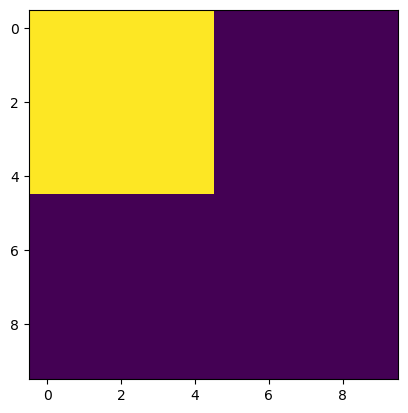

In [10]:
plt.imshow(X[0])

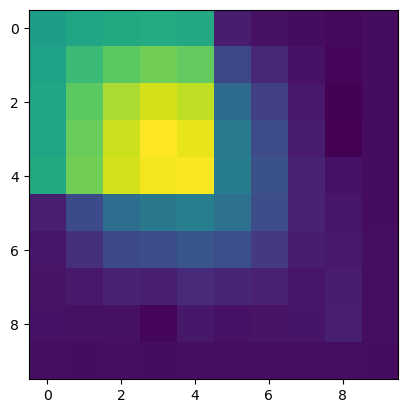

In [11]:
plt.imshow(Xhat[0])

In [12]:
def display_images_in_grid(imgs):
    M = imgs.shape[0]
    N = imgs.shape[1]
    fig, ax = plt.subplots(M, N)
    for m in range(M):
        for n in range(N):
            ax[m, n].set_axis_off()
            ax[m, n].imshow(imgs[m, n])
    fig.set_size_inches(10, 2.25)
    fig.tight_layout()

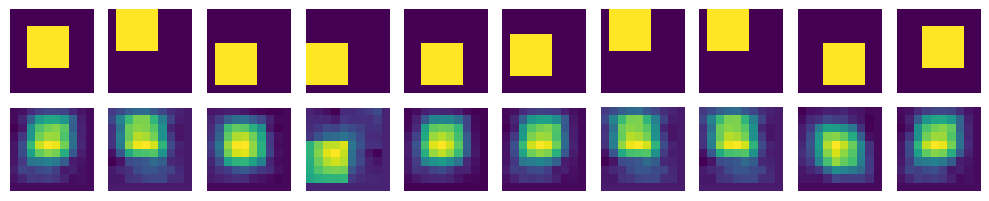

In [13]:
# Regenerations
r = torch.randint(low=0, high=X.shape[0], size=(num_images,))
imgs = torch.stack([X[r], Xhat[r]])
display_images_in_grid(imgs)

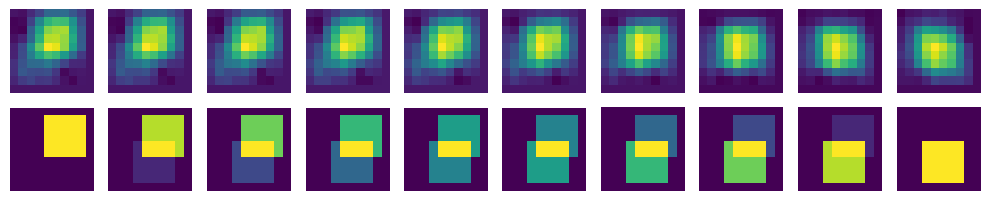

In [14]:
# Interpolations
r = torch.randint(low=0, high=X.shape[0], size=(2,))
base_X1 = X[r[0]]
base_X2 = X[r[1]]
base_Z1 = Z[r[0]]
base_Z2 = Z[r[1]]
semantic_interpolations = []
visual_interpolations = []
for k in range(num_images):
    theta = k / (num_images - 1)
    
    sem = theta * base_Z1 + (1 - theta) * base_Z2
    semantic_interpolations.append(sem)
    
    vis = theta * base_X1 + (1 - theta) * base_X2
    visual_interpolations.append(vis)
    
semantic_interpolations = torch.stack(semantic_interpolations)
semantic_interpolations = g(semantic_interpolations)
semantic_interpolations = ipca(semantic_interpolations, FX_mean, V)
semantic_interpolations = ifft(semantic_interpolations)

visual_interpolations = torch.stack(visual_interpolations)

interpolations = torch.stack((semantic_interpolations, visual_interpolations))
display_images_in_grid(interpolations)

In [15]:
torch.linalg.norm(interpolations[0] - interpolations[1])

tensor(8.9758)